# Introduction

This notebook will try to predict BTC price through:
- RNN: Recurrent Neural Network
- LSTM: Long Short Term Memory
- ES: Early Stopping
- Single-Step and Multi-Step time series forecasting
- Univariate (only input Price) and Multivariate (inputs Price and Volume)

https://nbviewer.jupyter.org/github/sjuanandres0/crypto/blob/main/Main.ipynb

# Parameter settings

In [1]:
# number of total past observations from the original dataset to be considered
n_past_total = 1200

# number of past observations to be considered for the LSTM training and prediction
n_past = 30

# number of future datapoints to predict (if higher than 1, the model switch to Multi-Step)
n_future = 10

# activation function used for the RNN (softsign, relu, sigmoid)
activation = 'softsign'

# dropout for the hidden layers
dropout = 0.2

# number of hidden layers
n_layers = 8

# number of neurons of the hidden layers
n_neurons = 20

# features to be considered for training (if only one is Close, then its Univariate, if more, then it's Multivariate)
features = ['Close', 'Volume']
#features = ['Close']

# number of inputs features (if higher than 1, )
n_features = len(features)

# patience for the early stopping (number of epochs)
patience = 25

# optimizer (adam, RMSprop)
optimizer='adam'

# Importing libraries

In [2]:
import os
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x) #avoid scientific notation
import datetime
import math
from matplotlib import pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

# Importing the files

In [3]:
# reading csv
dataset = pd.read_csv('data/yahoo_BTC-USD.csv')
dataset

Date      Open      High       Low     Close  Adj Close  \
0     2014-09-17   465.864   468.174   452.422   457.334    457.334   
1     2014-09-18   456.860   456.860   413.104   424.440    424.440   
2     2014-09-19   424.103   427.835   384.532   394.796    394.796   
3     2014-09-20   394.673   423.296   389.883   408.904    408.904   
4     2014-09-21   408.085   412.426   393.181   398.821    398.821   
...          ...       ...       ...       ...       ...        ...   
2454  2021-06-06 35538.609 36436.422 35304.578 35862.379  35862.379   
2455  2021-06-07 35835.266 36790.570 33480.641 33560.707  33560.707   
2456  2021-06-08 33589.520 34017.387 31114.443 33472.633  33472.633   
2457  2021-06-09 33416.977 37537.371 32475.865 37345.121  37345.121   
2458  2021-06-10 37513.863 37513.863 36615.184 36625.629  36625.629   

              Volume  
0       21056800.000  
1       34483200.000  
2       37919700.000  
3       36863600.000  
4       26580100.000  
...              ...  
2454 28913440585.000  
2455 33683936663.000  
2456 49902050442.000  
2457 53972919008.000  
2458 52061741056.000  

[2459 rows x 7 columns]

# EDA (brief)

In [4]:
# checking for nulls
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2459 entries, 0 to 2458
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2459 non-null   object 
 1   Open       2455 non-null   float64
 2   High       2455 non-null   float64
 3   Low        2455 non-null   float64
 4   Close      2455 non-null   float64
 5   Adj Close  2455 non-null   float64
 6   Volume     2455 non-null   float64
dtypes: float64(6), object(1)
memory usage: 134.6+ KB


In [5]:
# checking if close is not equal to adj close
dataset[dataset['Close']!=dataset['Adj Close']]

Date  Open  High  Low  Close  Adj Close  Volume
2039  2020-04-17   nan   nan  nan    nan        nan     nan
2214  2020-10-09   nan   nan  nan    nan        nan     nan
2217  2020-10-12   nan   nan  nan    nan        nan     nan
2218  2020-10-13   nan   nan  nan    nan        nan     nan

In [6]:
# checking the main parameters
dataset.describe()

Open      High       Low     Close  Adj Close           Volume
count  2455.000  2455.000  2455.000  2455.000   2455.000         2455.000
mean   7682.998  7903.197  7440.796  7696.541   7696.541  12680146147.817
std   11719.942 12089.894 11283.752 11731.193  11731.193  19763751064.923
min     176.897   211.731   171.510   178.103    178.103      5914570.000
25%     461.941   467.522   455.721   461.874    461.874     68840948.000
50%    4332.820  4413.090  4160.860  4338.710   4338.710   4047850000.000
75%    9219.190  9371.618  9041.198  9231.573   9231.573  18823342711.500
max   63523.754 64863.098 62208.965 63503.457  63503.457 350967941479.000

In [7]:
# use close only and fill NaN with ffil
df = dataset.set_index('Date')[features]#.tail(n_past_total)
df = df.set_index(pd.to_datetime(df.index))
df.fillna(method='ffill',inplace=True)

In [8]:
# looking at the correlation of the main possible variables
dataset[['Close','Volume']].corr()

Close  Volume
Close   1.000   0.799
Volume  0.799   1.000

In [9]:
# plotting Closing Price and Volume
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(go.Scatter(x=dataset['Close'].index, y=dataset['Close'].values, name='Close'), secondary_y=False)

fig.add_trace(go.Scatter(x=dataset['Volume'].index, y=dataset['Volume'].values, name='Volume'), secondary_y=True)

# Add figure title
fig.update_layout(title_text="BTC: {}, {}".format('Close', 'Volume'))

# Set x-axis title
fig.update_xaxes(title_text='<b>Date</b>')

# Set y-axes titles
fig.update_yaxes(title_text='<b>Close</b>', secondary_y=False)
fig.update_yaxes(title_text='<b>Volume</b>', secondary_y=True)

# Adding slider
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

We can observe a spike in volume around end of Feb2021. Let's take a look.

In [10]:
# looking at Feb21 datapoints
dataset[(dataset['Date']>'2021-02-01') & (dataset['Date']<'2021-03-01')].style.bar(subset=['Volume'], color='#d65f5f')

After checking from a different source, the Volume for 2021-02-26 seems to be correct (USD 350.967.941.479). Looks like that day was crazy.
https://coinmarketcap.com/historical/20210226/

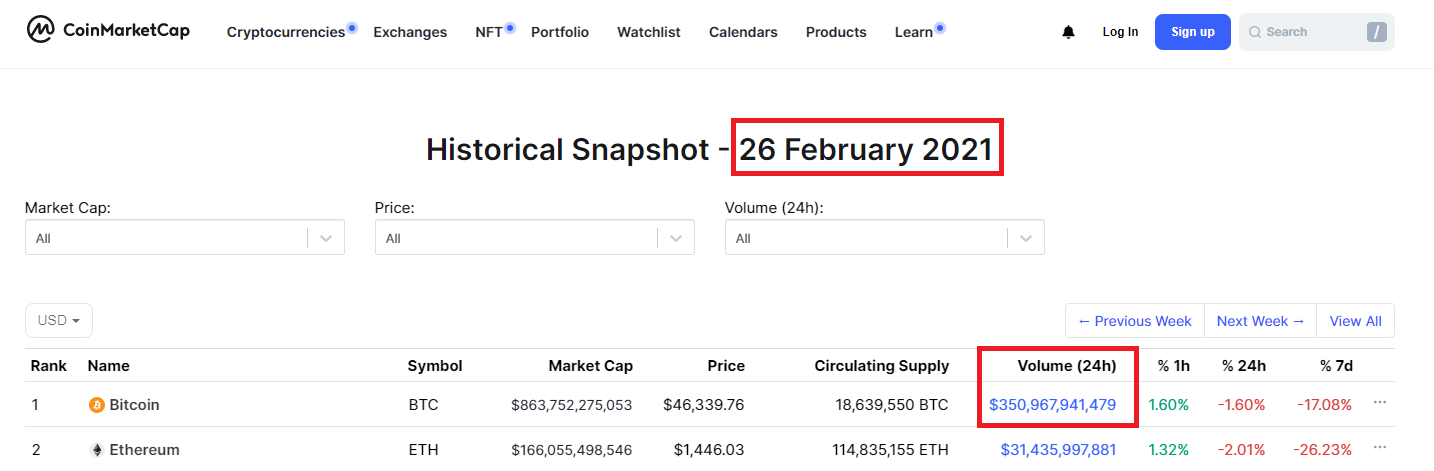

In [11]:
Image('img/coinmarketcap-20210226.png')

# Preprocessing the data

In [12]:
# droppping firsts observations becuase they may not be representative of BTC behaviour now due to beginnings of crypto market
df = df.tail(n_past_total)

In [13]:
# train test split
training_set = df.values
print('training_set.shape:\t', training_set.shape)

training_set.shape:	 (1200, 2)


In [14]:
# scale
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
print('training_set_scaled.shape: ', training_set_scaled.shape)
training_set_scaled

training_set_scaled.shape:  (1200, 2)


array([[0.12426163, 0.01161493],
       [0.11882415, 0.01152876],
       [0.12800168, 0.01262371],
       ...,
       [0.50170116, 0.13497817],
       [0.56595702, 0.14667458],
       [0.55401855, 0.14118339]])

In [15]:
# creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []

for i in range(n_past, len(training_set_scaled) - n_future + 1):
    X_train.append(training_set_scaled[i-n_past:i, :])
    y_train.append(training_set_scaled[i:i+n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((1161, 30, 2), (1161, 10))

In [16]:
# reshaping (needed to fit RNN)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
X_train.shape

(1161, 30, 2)

# RNN - LSTM with early stopping and dropout regularization 
Build and fit

In [17]:
# Building the RNN

# Initialising the RNN
regressor = Sequential()

# Input layer
regressor.add(LSTM(units=n_past, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], n_features))) 
#regressor.add(LSTM(units=neurons, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], 1))) 

# Hidden layers
for _ in range(n_layers):
    regressor.add(Dropout(dropout))
    regressor.add(LSTM(units=n_neurons, return_sequences=True, activation=activation))

# Last hidden layer (changing the return_sequences)
regressor.add(Dropout(dropout))
regressor.add(LSTM(units=n_neurons, return_sequences=False, activation=activation))

# Adding the output layer
regressor.add(Dense(units=n_future))

# Compiling the RNN
regressor.compile(optimizer=optimizer, loss='mse')

# Model summary
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 30)            3960      
_________________________________________________________________
dropout (Dropout)            (None, 30, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 20)            4080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 20)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 20)            3280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 20)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 20)            3

In [18]:
# Adding early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

In [19]:
# Fitting the RNN to the Training set
res = regressor.fit(X_train, y_train
                    , batch_size=32
                    , epochs=750
                    , validation_split=0.1
                    , callbacks=[early_stop]
                   )

Epoch 1/750
33/33 [==============================] - 27s 136ms/step - loss: 0.0203 - val_loss: 0.5045
Epoch 2/750
33/33 [==============================] - 2s 49ms/step - loss: 0.0105 - val_loss: 0.4923
Epoch 3/750
33/33 [==============================] - 2s 48ms/step - loss: 0.0102 - val_loss: 0.3013
Epoch 4/750
33/33 [==============================] - 2s 47ms/step - loss: 0.0039 - val_loss: 0.0947
Epoch 5/750
33/33 [==============================] - 2s 47ms/step - loss: 0.0020 - val_loss: 0.1120
Epoch 6/750
33/33 [==============================] - 2s 47ms/step - loss: 0.0018 - val_loss: 0.0773
Epoch 7/750
33/33 [==============================] - 2s 47ms/step - loss: 0.0016 - val_loss: 0.0814
Epoch 8/750
33/33 [==============================] - 2s 48ms/step - loss: 0.0014 - val_loss: 0.0671
Epoch 9/750
33/33 [==============================] - 2s 48ms/step - loss: 0.0015 - val_loss: 0.0722
Epoch 10/750
33/33 [==============================] - 2s 48ms/step - loss: 0.0014 - val_loss: 0.07

In [20]:
# Exporting the regressor
last_date = dataset.Date.values[-1]
params = ['reg', last_date, n_past_total, n_past, n_future, activation, n_layers, n_neurons, n_features, patience, optimizer]
modelname = 'output/'
for i in params:
    modelname += str(i)
    if i!= params[-1]:
        modelname += '_'
if not os.path.exists(modelname):
    os.makedirs(modelname)
regressor.save('{}/regressor.h5'.format(modelname))

In [21]:
list(res.history)

['loss', 'val_loss']

# Validation

In [22]:
# Plotting Loss/MSE

results = res

history = results.history
plt.figure(figsize=(12,4))
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('{}/Loss.png'.format(modelname))
plt.show()

In [23]:
def dummy_invscaler(y, n_features):
    '''
    Since the scaler was trained into 2 features, it needs two features to perform the inverse scaleer.
    For that purpose, this function will create a dummy array and concatenate it to the y_pred/y_true.
    That dummy of ones will be drop after performing the inverse_transform.
    INPUTS: array 'y', shape (X,)
    '''
    y = np.array(y).reshape(-1,1)
    if n_features>1:
        dummy = np.ones((len(y), n_features-1))
        y = np.concatenate((y, dummy), axis=1)
        y = sc.inverse_transform(y)
        y = y[:,0]
    else:
        y = sc.inverse_transform(y)
    return y

y_pred:
 [37148.42007106434, 37375.90173512726, 37340.001538518474, 37676.947550316, 38732.70573365663, 39165.05632037239, 39478.00301122301, 39727.33587560325, 40236.67395618728, 40719.41198114914]
y_true:
 [[36684.925781], [37575.179688], [39208.765625], [36894.40625], [35551.957031], [35862.378906], [33560.707031], [33472.632813], [37345.121094], [36625.628906]]


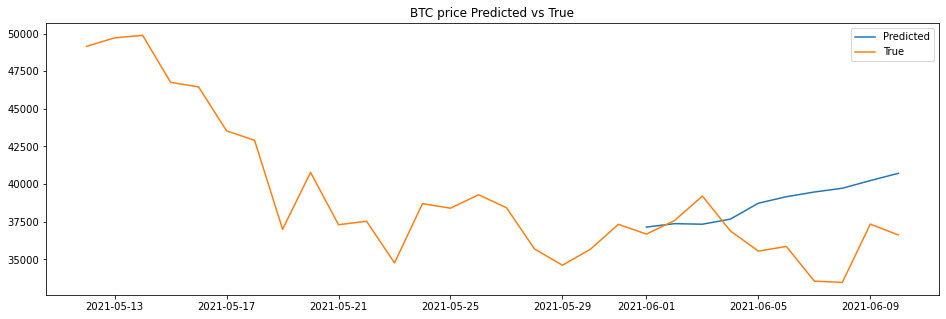

In [24]:
# Validation

# getting the predictions
y_pred = regressor.predict(X_train[-1].reshape(1, n_past, n_features)).tolist()[0]
y_pred = dummy_invscaler(y_pred, n_features)

# creating a DF of the predicted prices
y_pred_df = pd.DataFrame(y_pred, 
                         index=df[['Close']].tail(n_future).index, 
                         columns=df[['Close']].columns)

# getting the true values
y_true_df = df[['Close']].tail(n_past)
y_true = y_true_df.tail(n_future).values

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred_df, label='Predicted')
plt.plot(y_true_df, label='True')

plt.title('BTC price Predicted vs True')
plt.legend()
plt.savefig('{}/Validation.png'.format(modelname))
plt.show()

In [25]:
# Root Mean Square Error (RMSE)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
rmse

3530.4372124427737

In [26]:
# Mean Square Error (MSE)
mse = mean_absolute_error(y_true, y_pred)
mse

2895.4838726926305

In [27]:
#Explained variance regression score function.
explained_variance_score(y_true, y_pred)
# Best possible score is 1.0, lower values are worse.

-1.2490513116772766

# Predictions

In [28]:
# Predicting/Forecasting

# getting the predictions
x = df[features][-n_past:].values
x = sc.transform(x)
y_pred = regressor.predict(x.reshape(1, n_past, n_features)).tolist()[0]
y_pred = dummy_invscaler(y_pred, n_features)

# creating a DF of the predicted prices
y_pred_df = pd.DataFrame(y_pred, 
                         index=pd.date_range(start=df[['Close']].index[-1]+datetime.timedelta(days=1),
                                             periods=len(y_pred), 
                                             freq="D"), 
                         columns=df[['Close']].columns)

# getting the true values
y_true_df = df[['Close']].tail(n_past)

# linking them
#y_true_df = y_true_df.append(y_pred_df.head(1))
y_pred_df = y_pred_df.append(y_true_df.tail(1)).sort_index()

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred_df, label='Predicted')
plt.plot(y_true_df, label='True')

plt.title('BTC price Predicted vs True')
plt.legend()
plt.savefig('{}/Predictions.png'.format(modelname))
plt.show()

y_pred:
 [37012.387997282254, 37245.56685084102, 37207.198830030684, 37543.77484780673, 38584.722493763125, 39018.28723561734, 39340.4047491558, 39586.88901878811, 40092.390656508614, 40572.0106736001]
y_true:
 [[36684.925781], [37575.179688], [39208.765625], [36894.40625], [35551.957031], [35862.378906], [33560.707031], [33472.632813], [37345.121094], [36625.628906]]


In [29]:
# export to csv
y_pred_df.to_csv('{}/preds_{}.csv'.format(modelname,n_future))
# show
y_pred_df

Close
2021-06-10 36625.629
2021-06-11 37012.388
2021-06-12 37245.567
2021-06-13 37207.199
2021-06-14 37543.775
2021-06-15 38584.722
2021-06-16 39018.287
2021-06-17 39340.405
2021-06-18 39586.889
2021-06-19 40092.391
2021-06-20 40572.011